In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import seaborn as sns

from imblearn.over_sampling import SMOTE as smote
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

# Parse Data

In [2]:
df = pd.read_csv('assignment-data/data_for_student_case.csv', dtype={'bin':str, 'amount':int}, na_filter=False)
df = df.drop(['txid','bookingdate'], axis='columns')  # We are not interested in these columns (using booking date would be cheating)
df = df.rename(index=str, columns={'issuercountrycode':'issuercountry', 
                                   'bin':'issuer_id', 
                                   'shoppercountrycode':'shoppercountry', 
                                   'shopperinteraction':'interaction', 
                                   'cardverificationcodesupplied':'verification', 
                                   'cvcresponsecode':'cvcresponse', 
                                   'creationdate':'creationdate_stamp', 
                                   'simple_journal':'label'})  # Use column names which are more recognizable

# Skip data if:
df = df[df['label']!='Refused']
df = df[~df['issuer_id'].str.contains('na', case=False)]
df = df[~df['mail_id'].str.contains('na', case=False)]

# Create and format (new) columns
df['creationdate'] = (pd.to_datetime(df['creationdate_stamp'])).dt.date
df['issuer_id'] = pd.to_numeric(df['issuer_id'])
df['mail_id'] = pd.to_numeric(df['mail_id'].str.replace('email','')).astype(int)
df['ip_id'] = pd.to_numeric(df['ip_id'].str.replace('ip','')).astype(int)
df['card_id'] = pd.to_numeric(df['card_id'].str.replace('card','')).astype(int)
df['subscription'] = pd.to_numeric(df['interaction'].apply(lambda x: '1' if x == 'ContAuth' else '0'))
df['verification'] = pd.to_numeric(df['verification'].apply(lambda x: '1' if x else '0'))

# Label the data
df['label'] = pd.to_numeric(df['label'].apply(lambda x: '1' if x == 'Chargeback' else '0'))

df.loc[df['shoppercountry'] == df['issuercountry'], 'home_country'] = 1
df.loc[df['shoppercountry'] != df['issuercountry'], 'home_country'] = 0

# Preprocess Data

In [3]:
converter = {
    'AUD': 0.702495,
    'GBP': 1.305505,
    'MXN': 0.05274,
    'NZD': 0.6632,
    'SEK': 0.104965
}


# Function that can take two input values (amount, currency) and convert it to USD (using current ratios, not historic ones)
def convert_to_usd(args):
    amount, currency = args
    return converter[currency] * amount / 100

# Create a new column containing the transaction amount in USD to be able to compare the transaction amounts.
df['usd_amount'] = df[['amount', 'currencycode']].apply(convert_to_usd, axis=1)

# Create new dataframe with average expense per customer
avg_expense = df.groupby('card_id')['usd_amount'].mean().reset_index().rename(columns={'usd_amount': 'avg_amount'})
# Merge this new dataframe with our parsed dataset to obtain a column with average amounts
df = pd.merge(df, avg_expense, on='card_id', how='left')
# We are actually mainly interested in the difference between 
# the average transaction amount of this customer and the current transaction amount.
df['dif_avg_amount'] = df['usd_amount'] - df['avg_amount']

# Number of transactions in this country
ntc = df.groupby(['card_id', 'shoppercountry'])['amount'].agg(['count']).reset_index().rename(columns={'count': 'ntc'})
df = pd.merge(df, ntc, on=['card_id', 'shoppercountry'], how='left')

# Number of transactions for this interaction type
nti = df.groupby(['card_id', 'interaction'])['amount'].agg(['count']).reset_index().rename(columns={'count': 'nti'})
df = pd.merge(df, nti, on=['card_id', 'interaction'], how='left')

print(df.dtypes)

issuercountry          object
txvariantcode          object
issuer_id               int64
amount                  int64
currencycode           object
shoppercountry         object
interaction            object
label                   int64
verification            int64
cvcresponse             int64
creationdate_stamp     object
accountcode            object
mail_id                 int64
ip_id                   int64
card_id                 int64
creationdate           object
subscription            int64
home_country          float64
usd_amount            float64
avg_amount            float64
dif_avg_amount        float64
ntc                     int64
nti                     int64
dtype: object


In [4]:
print("Total amount:", len(df))
fraud = df[df['label']==1]
benign = df[df['label']==0]

Total amount: 236698


# Find interesting relationships in the data

In [5]:
number_of_fraudulent_cases = len(fraud)
print("Number of fraudulent cases:", number_of_fraudulent_cases)

number_of_benign_cases = len(benign)
print("Number of benign cases:", number_of_benign_cases)

Number of fraudulent cases: 345
Number of benign cases: 236353


In [6]:
not_same_country_benign = benign[benign['home_country'] != 1]
not_same_country_fraud = fraud[fraud['home_country'] != 1]
print("Fraction of benign data not in home country", len(not_same_country_benign) / len(benign))
print("Fraction of fraud data not in home country", len(not_same_country_fraud) / len(fraud))

Fraction of benign data not in home country 0.02904976877805655
Fraction of fraud data not in home country 0.04057971014492753


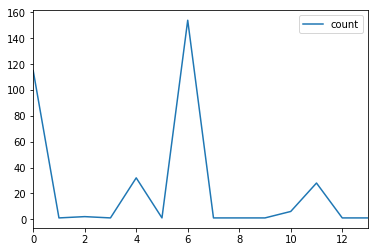

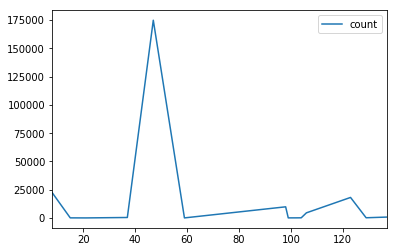

In [7]:
# The raw amounts from the fraud/benign transactions per country were further 
# processed in libre office to produce the graphs contained in the report (due to bug in pandas for python < 3.7).
amount_fraud_per_country = fraud.groupby('shoppercountry')['amount'].agg(['count']).reset_index()
fraudulent_countries = list(amount_fraud_per_country['shoppercountry'])
amount_fraud_per_country.plot()

amount_benign_per_country = benign.groupby('shoppercountry')['amount'].agg(['count']).reset_index()
amount_benign_per_country = amount_benign_per_country[pd.DataFrame(amount_benign_per_country.shoppercountry.tolist()).isin(fraudulent_countries).any(1)]
amount_benign_per_country.plot()

In [8]:
# Calculate average transaction amounts.
avg_usd_amount_fraud = fraud['usd_amount'].mean()
avg_usd_amount_benign = benign['usd_amount'].mean()
print("Average amount in USD for the fraudulent cases:", avg_usd_amount_fraud)
print("Average amount in USD for the benign cases:", avg_usd_amount_benign)

Average amount in USD for the fraudulent cases: 162.81484754202899
Average amount in USD for the benign cases: 87.06378282258906


# Compare sampling methods using ROC and AUC

In [35]:
def compare_sampling(classifier, classifier_name, sampling_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl):
    fig = plt.figure()
    
    plot_line_compare_sampling(classifier, classifier_name, 'normal', train_ft, test_ft, train_lbl, test_lbl)
    plot_line_compare_sampling(classifier, classifier_name, sampling_name, train_ft_smote, test_ft, train_lbl_smote, test_lbl)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparise %s for a %s with ROC curves' %(sampling_name, classifier_name))
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig(f'{classifier_name}{}{}')
    return classifier
    
def plot_line_compare_sampling(classifier, classifier_name, line_label, train_ft, test_ft, train_lbl, test_lbl):
    classifier.fit(train_ft, train_lbl)
    
    predict_lbl = classifier.predict_proba(test_ft)
    predict_lbl = predict_lbl[:, 1]
    
    predict_decision_lbl = classifier.predict(test_ft)
    print(line_label+':')
    print(confusion_matrix(test_lbl, predict_decision_lbl))
    
    fp_rate, tp_rate, thresholds = roc_curve(test_lbl, predict_lbl, pos_label =True)
    area = auc(fp_rate, tp_rate)
    plt.plot(fp_rate, tp_rate, label=('ROC %s (area = %0.2f)') %(line_label, area))
    
    if classifier_name == "Decision Tree":
        export_graphviz(classifier, out_file='tree_%s.dot' %(line_label))   
    

In [36]:
def try_sampling(sampler, sampler_name):
    data_ft = df[['usd_amount', 'dif_avg_amount', 'ntc', 'home_country', 'cvcresponse', 'verification']].values
    data_lbl = df[['label']].values.ravel()

    train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)
    train_ft_smote, train_lbl_smote = sampler.fit_sample(train_ft,train_lbl)

    cl1 = compare_sampling(DecisionTreeClassifier(max_depth=4), "Decision Tree", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    cl2 = compare_sampling(RandomForestClassifier(n_estimators=10), "Random Forest", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    cl3 = compare_sampling(GaussianNB(), "Gaussian Naive Bayes", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    cl4 = compare_sampling(AdaBoostClassifier(), "Ada Boost", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    cl5 = compare_sampling(GradientBoostingClassifier(), "Gradient Boosting", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
#     cl6 = compare_sampling(VotingClassifier([cl1, cl2, cl3, cl4, cl5], method='all'), "Gradient Boosting", sampler_name, train_ft, train_ft_smote, test_ft, train_lbl, train_lbl_smote, test_lbl)
    

In [47]:
def train_clf(classifier, classifier_name, train_ft, test_ft, train_lbl, test_lbl):
#     if classifier_name != 'Voting':
    classifier.fit(train_ft, train_lbl)
    predict_decision_lbl = classifier.predict(test_ft)
    print(classifier_name +':')
    print(confusion_matrix(test_lbl, predict_decision_lbl))
    return classifier
    
data_ft = df[['usd_amount', 'dif_avg_amount', 'ntc', 'home_country', 'cvcresponse', 'verification']].values
data_lbl = df[['label']].values.ravel()
train_ft, test_ft, train_lbl, test_lbl = train_test_split(data_ft,data_lbl,test_size=0.2)
sampler = smote(sampling_strategy = 'minority')
train_ft_smote, train_lbl_smote = sampler.fit_sample(train_ft,train_lbl)

# sampler = SMOTETomek(ratio = 'auto')
# train_ft_smote_t, train_lbl_smote_t = sampler.fit_sample(train_ft,train_lbl)

cl1 = train_clf(DecisionTreeClassifier(max_depth = 4), "Decision Tree", train_ft_smote, test_ft, train_lbl_smote, test_lbl)
cl2 = train_clf(RandomForestClassifier(n_estimators=10), "Random Forest", train_ft_smote, test_ft, train_lbl_smote, test_lbl)
cl3 = train_clf(GaussianNB(), "Gaussian Naive Bayes", train_ft, test_ft, train_lbl, test_lbl)
cl4 = train_clf(VotingClassifier(estimators=[('DTC', cl1), ('RFC', cl2), ('GNBC', cl3)], voting='hard'), 
                'Voting',train_ft, test_ft, train_lbl, test_lbl)


Decision Tree:
[[39417  7862]
 [   14    47]]
Random Forest:
[[46468   811]
 [   47    14]]
Gaussian Naive Bayes:
[[46899   380]
 [   55     6]]
Voting:
[[47275     4]
 [   60     1]]


# SMOTE

normal:
[[47270     0]
 [   70     0]]
SMOTE:
[[38563  8707]
 [    5    65]]


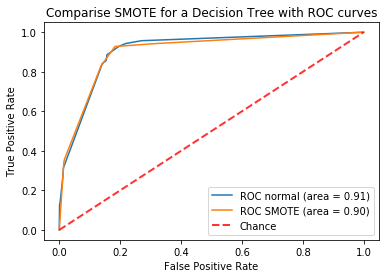

normal:
[[47259    11]
 [   63     7]]
SMOTE:
[[46360   910]
 [   44    26]]


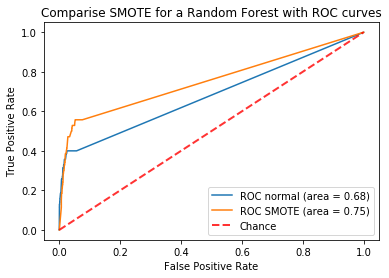

normal:
[[46871   399]
 [   60    10]]
SMOTE:
[[38949  8321]
 [   11    59]]


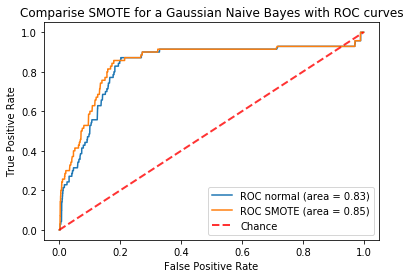

normal:
[[47266     4]
 [   70     0]]
SMOTE:
[[39284  7986]
 [    7    63]]


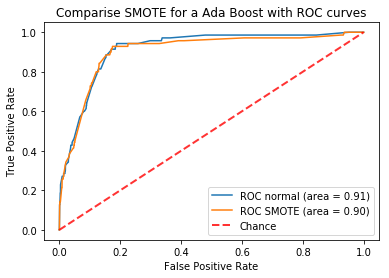

normal:
[[47268     2]
 [   69     1]]
SMOTE:
[[40968  6302]
 [   10    60]]


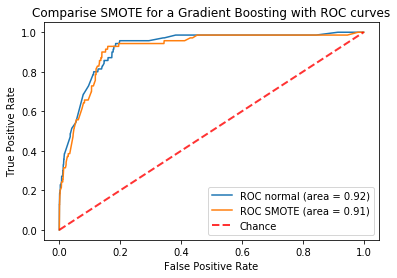

In [37]:
sm = smote(sampling_strategy = 'minority')
try_sampling(sm, 'SMOTE')

normal:
[[47263    14]
 [   60     3]]
Tomek Links:
[[47261    16]
 [   59     4]]


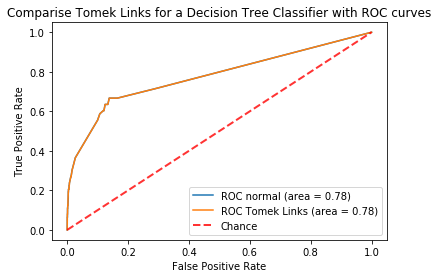

normal:
[[47251    26]
 [   59     4]]
Tomek Links:
[[47252    25]
 [   60     3]]


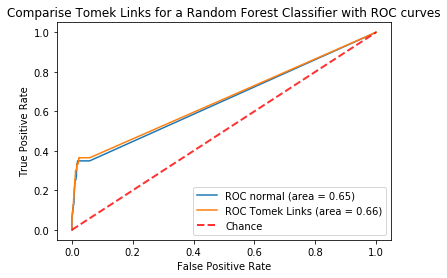

normal:
[[46941   336]
 [   53    10]]
Tomek Links:
[[46941   336]
 [   53    10]]


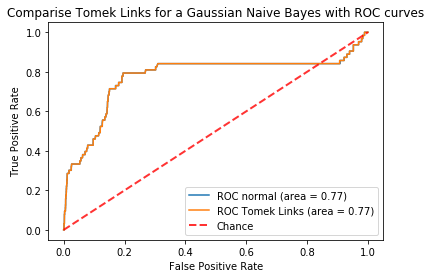

normal:
[[47273     4]
 [   63     0]]
Tomek Links:
[[47273     4]
 [   63     0]]


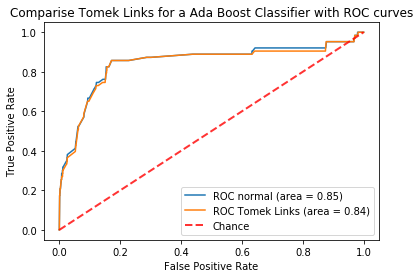

In [12]:
tl = TomekLinks(ratio='majority')
try_sampling(tl, 'Tomek Links')

normal:
[[47258    13]
 [   69     0]]
SMOTE + Tomek Links:
[[41627  5644]
 [   16    53]]


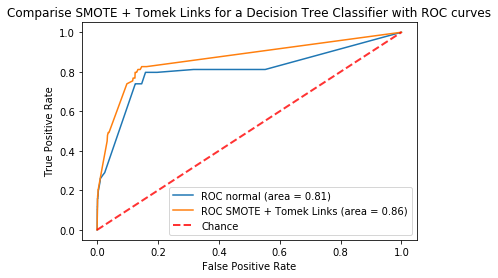

normal:
[[47262     9]
 [   67     2]]
SMOTE + Tomek Links:
[[46251  1020]
 [   43    26]]


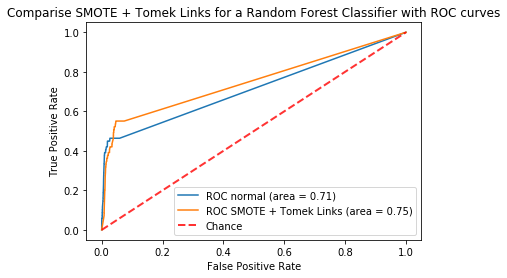

normal:
[[46889   382]
 [   54    15]]
SMOTE + Tomek Links:
[[38929  8342]
 [    5    64]]


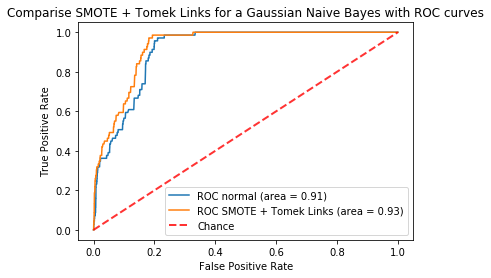

normal:
[[47269     2]
 [   69     0]]
SMOTE + Tomek Links:
[[39372  7899]
 [    6    63]]


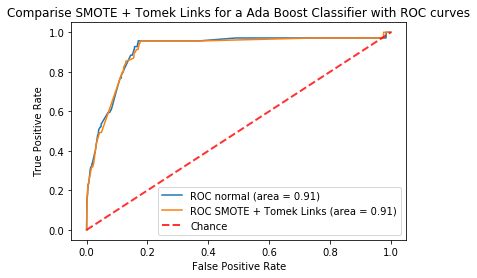

In [13]:
smt = SMOTETomek(ratio='auto')
try_sampling(smt, 'SMOTE + Tomek Links')

normal:
[[47261     6]
 [   72     1]]
Random Under Sampling:
[[36416 10851]
 [   12    61]]


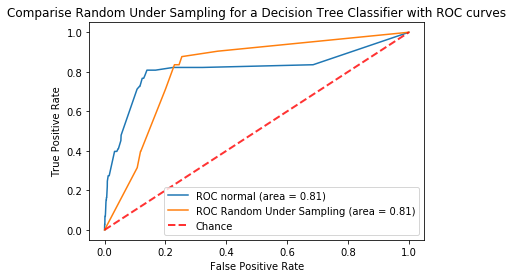

normal:
[[47256    11]
 [   70     3]]
Random Under Sampling:
[[38857  8410]
 [   19    54]]


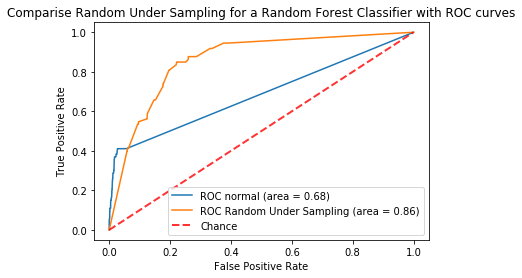

normal:
[[47047   220]
 [   65     8]]
Random Under Sampling:
[[41741  5526]
 [   47    26]]


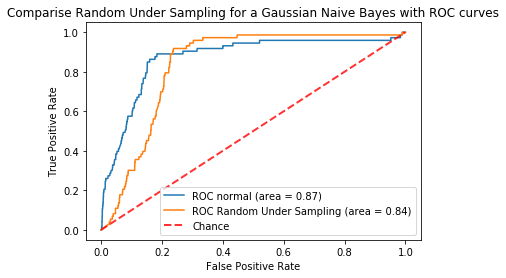

normal:
[[47267     0]
 [   73     0]]
Random Under Sampling:
[[35821 11446]
 [    4    69]]


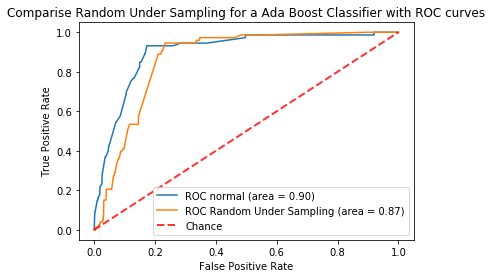

In [14]:
rus = RandomUnderSampler()
try_sampling(rus, 'Random Under Sampling')